### todo
---
add some metrics 

In [2]:
import gif
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error


In [3]:
sns.set_style("darkgrid")
sns.set_context("talk")


In [4]:
def fig_number_gen():
    """generator that will yield 0 to inf    
    """
    num = 0
    while True:
        yield num
        num += 1

fig_num = fig_number_gen()


In [5]:
# loading time-series data
df = pd.read_csv(
    "https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv"
)
df["ds"] = pd.to_datetime(df["ds"])
print(df.head())
print(df.info())



          ds         y
0 2007-12-10  9.590761
1 2007-12-11  8.519590
2 2007-12-12  8.183677
3 2007-12-13  8.072467
4 2007-12-14  7.893572
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2905 non-null   datetime64[ns]
 1   y       2905 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 45.5 KB
None


In [6]:
# subsetting the data
df_train = df[(df["ds"] >= "01-01-2011") & (df["ds"] <= "31-12-2014")]
df_test = df[(df["ds"] > "31-12-2014")]

# creating a train test frame for convience later
df_train_test = pd.concat([df_train, df_test])


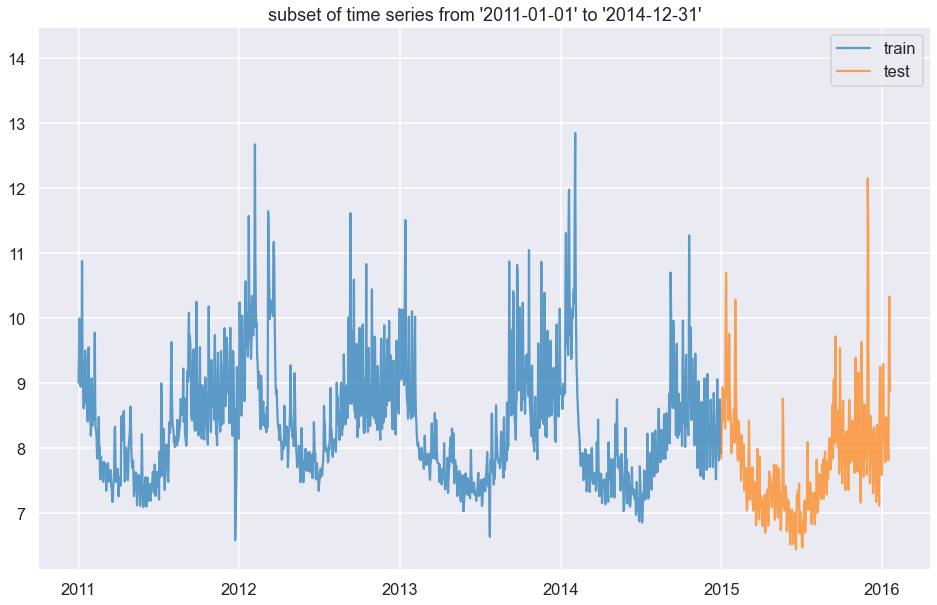

In [7]:
plt.figure(figsize=(16, 10))
plt.plot_date(x=df_train["ds"], y=df_train["y"], fmt="-", label="train", alpha=0.7)
plt.plot_date(x=df_test["ds"], y=df_test["y"], fmt="-", label="test", alpha=0.7)

plt.ylim(top=plt.ylim()[1] * 1.1)  # stretching the top of the plot by 10%
plt.title(
    f"subset of time series from {df_train['ds'].iloc[0]:'%Y-%m-%d'} to {df_train['ds'].iloc[-1]:'%Y-%m-%d'}"
)
plt.legend()
plt.savefig(f"figs/{next(fig_num)}_subset_time_series.png")
plt.show()



In [8]:
# convert the datetime to floats
time_scaler = MinMaxScaler()

# shape the inputs
X_train = time_scaler.fit_transform(df_train.index.values.reshape(-1, 1))
y_train = df_train["y"].values.reshape(-1, 1)

# fit the lin reg to the train set
reg = LinearRegression().fit(X_train, y_train)

In [9]:
# predict using the dates of the test set
X_predict = time_scaler.transform(df_train_test.index.values.reshape(-1, 1))
y_predict = reg.predict(X_predict)


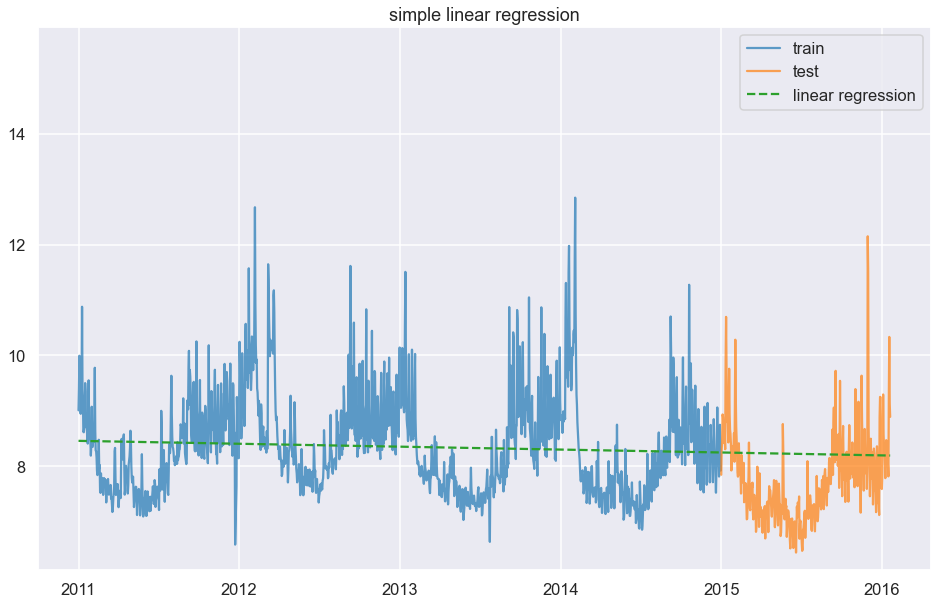

In [10]:
# plot the subset with
plt.figure(figsize=(16, 10))
plt.plot_date(x=df_train["ds"], y=df_train["y"], fmt="-", label="train", alpha=0.7)
plt.plot_date(x=df_test["ds"], y=df_test["y"], fmt="-", label="test", alpha=0.7)
plt.ylim(top=plt.ylim()[1] * 1.1)  # stretching the top of the plot by 10%

plt.plot_date(x=df_train_test["ds"], y=y_predict, fmt="--", label="linear regression")
plt.legend()
plt.ylim(top=plt.ylim()[1] * 1.1)  # stretching the top of the plot by 10%
plt.title("simple linear regression")
plt.savefig(f"figs/{next(fig_num)}_subset_time_series_w_linreg.png")
plt.show()



In [11]:
print(reg.intercept_)
print(reg.coef_)


[8.45829284]
[[-0.20970805]]


In [12]:
# adding month dummies to train and test
df_train_test = df_train_test.assign(month=df_train_test["ds"].dt.month)
df_train = df_train.assign(month=df_train["ds"].dt.month)
df_test = df_test.assign(month=df_test["ds"].dt.month)

df_train_test = pd.get_dummies(df_train_test, columns=["month"], dtype="bool")
df_train = pd.get_dummies(df_train, columns=["month"], dtype="bool")
df_test = pd.get_dummies(df_test, columns=["month"], dtype="bool")


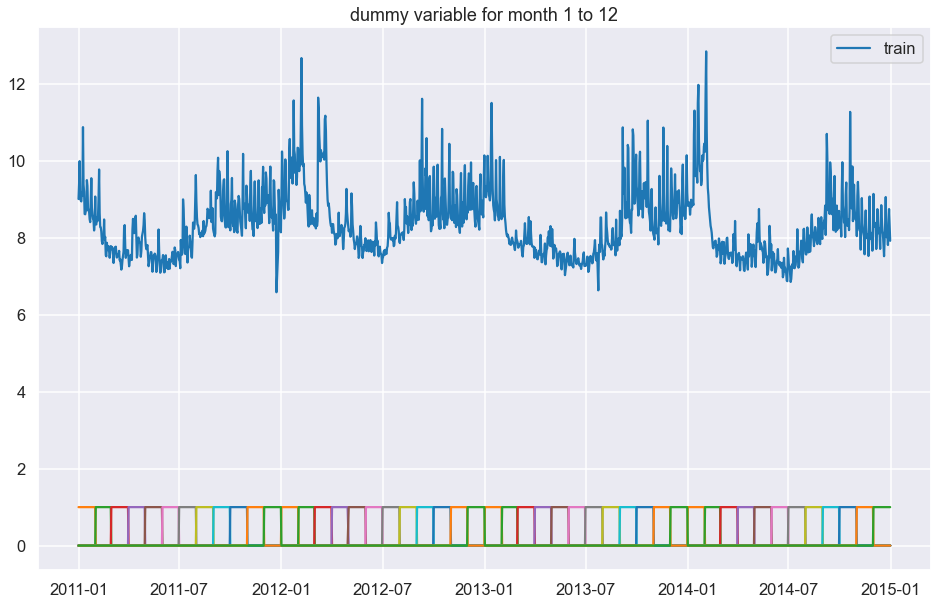

In [13]:
# plot the subset with
plt.figure(figsize=(16, 10))
plt.plot_date(x=df_train["ds"], y=df_train["y"], fmt="-", label="train")
plt.legend()
for i in range(1, 13):
    plt.plot_date(
        x=df_train["ds"], y=df_train[f"month_{i}"], fmt="-", label=f"month {i}"
    )

    plt.title(f"dummy variable for month 1 to {i}")
    plt.savefig(f"figs/{next(fig_num)}_subset_time_series_w_month_{i}.png")

plt.show()


In [14]:
# create gif w month dummy
@gif.frame
def subset_time_series_w_month_gif(i: int):
    """
    i in range 1 up to and include 12
    """
    plt.figure(figsize=(16, 10))
    plt.plot_date(x=df_train["ds"], y=df_train["y"], fmt="-", label="train")
    plt.legend()
    for i in range(1, i):
        plt.plot_date(
            x=df_train["ds"], y=df_train[f"month_{i}"], fmt="-", label=f"month {i}"
        )

        plt.title(f"dummy variable for month 1 to {i}")


frames = [subset_time_series_w_month_gif(i) for i in range(1, 14)][1:]
gif.save(frames, f"figs/{next(fig_num)}subset_time_series_w_month_gif.gif", duration=400)


In [15]:
# shape the inputs
X_month = np.hstack(
    [
        time_scaler.fit_transform(df_train.index.values.reshape(-1, 1)),
        df_train.loc[:, ~df_train.columns.isin(["y", "ds"])].values,
    ]
)
y_month = df_train.loc[:, "y"].values.reshape(-1, 1)

# fit the lin reg
reg_month = LinearRegression().fit(X_month, y_month)

# predict using the dates of the train and test set
X_predict_month = np.hstack(
    [
        time_scaler.fit_transform(df_train_test.index.values.reshape(-1, 1)),
        df_train_test.loc[:, ~df_train_test.columns.isin(["y", "ds"])].values,
    ]
)
y_predict_month = reg_month.predict(X_predict_month)


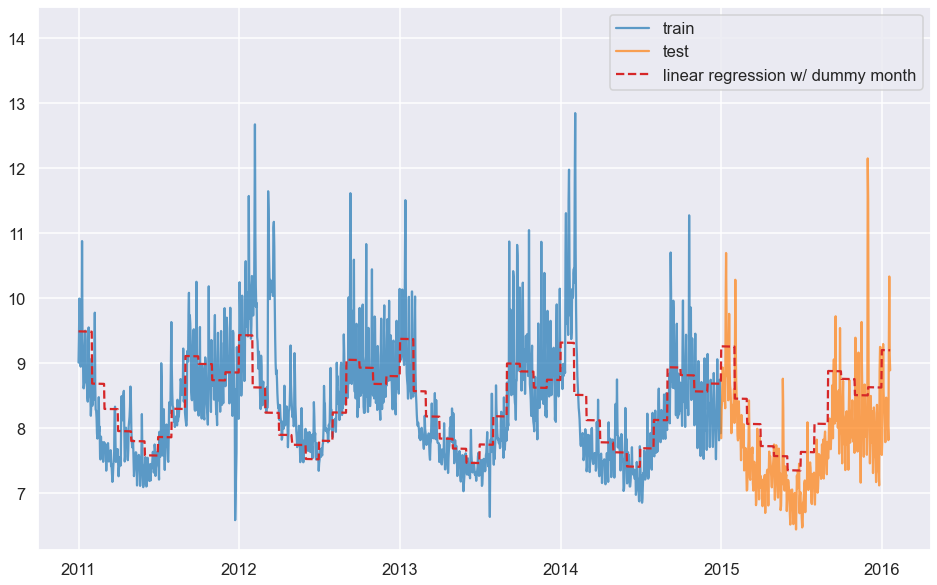

In [16]:
# plot the subset with
plt.figure(figsize=(16, 10))
plt.plot_date(x=df_train["ds"], y=df_train["y"], fmt="-", label="train", alpha=0.7)
plt.plot_date(x=df_test["ds"], y=df_test["y"], fmt="-", label="test", alpha=0.7)
plt.ylim(top=plt.ylim()[1] * 1.1)  # stretching the top of the plot by 10%

plt.plot_date(
    x=df_train_test["ds"],
    y=y_predict_month,
    fmt="--",
    label="linear regression w/ dummy month",
    c=sns.color_palette()[3],  # selecting this color, think it looks better
)
plt.legend()

# plt.title("simple linear regression")
plt.savefig(f"figs/{next(fig_num)}_subset_time_series_w_linreg.png")
plt.show()

In [17]:
# Metrics
X_predict = time_scaler.transform(df_test.index.values.reshape(-1, 1))

X_predict_month = np.hstack(
    [
        time_scaler.fit_transform(df_test.index.values.reshape(-1, 1)),
        df_test.loc[:, ~df_test.columns.isin(["y", "ds"])].values,
    ]
)

y_predict = reg.predict(X_predict)
y_predict_month = reg_month.predict(X_predict_month)

metrics_ols = {
    "model": "no dummies",
    "mse": [mean_squared_error(y_true=df_test["y"].values, y_pred=y_predict)],
    "mape": [
        mean_absolute_percentage_error(y_true=df_test["y"].values, y_pred=y_predict)
    ],
    "mae":[ mean_absolute_error(y_true=df_test["y"].values, y_pred=y_predict)],
}


metrics_month = {
    "model": "months",
    "mse": [mean_squared_error(y_true=df_test["y"].values, y_pred=y_predict_month)],
    "mape": [
        mean_absolute_percentage_error(
            y_true=df_test["y"].values, y_pred=y_predict_month
        )
    ],
    "mae":[ mean_absolute_error(y_true=df_test["y"].values, y_pred=y_predict_month)],
}



In [18]:
df_metrics = pd.concat([pd.DataFrame( data= metrics_ols),pd.DataFrame( data= metrics_month)])
df_metrics.head(10)

,model,mse,mape,mae
0,no dummies,0.825734,0.099583,0.749854
0,months,0.702991,0.096196,0.738989
